# COVID-19 Prediction

## Data

Per country daily new cases and new deaths: [here](https://opendata.ecdc.europa.eu/covid19/casedistribution/csv).

In [26]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

def logistic(t, a, b, c):
    return a/(1 + np.exp(b*(t - c)))

def synchronize(weights, data, derivative=False, precision=0.00001):
    def half(a, b):
        return (a + b)/2
    a = 1e-20
    b = 1
    t = range(len(data))
    # plt.plot(data, 'k.')
    def _inte(d):
        return (data - integrate(weights, [d], t, derivative=derivative)).mean()
    while b-a > precision:
        guess_a = _inte(a)
        guess_b = _inte(b)
        c = half(a, b)
        # plt.plot(integrate(weights, [a], t, derivative=derivative))
        guess_c = _inte(c)
        if guess_a * guess_c > 0:
            a = c
        else:
            b = c
    # plt.show()
    return c

def find_beginning(values):
    for i, val in enumerate(values):
        if val > 10:
            return i
    return 0

data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv') # 'C:/Users/kipr/Downloads/téléchargement.csv'

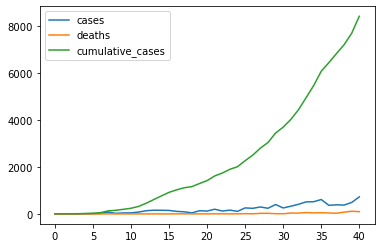

In [28]:
country_data = data[data['geoId'] == 'SE'].copy()
country_data.loc[:, 'dateRep'] = pd.to_datetime(country_data['dateRep'], dayfirst=True)
values = country_data.sort_values('dateRep')[['cases', 'deaths', 'popData2018']].values[60:]

backscaling = 10000
plt.plot(values[:, 0], label='cases')
plt.plot(values[:, 1], label='deaths')
plt.plot(np.cumsum(values[:, 0]), label='cumulative_cases')
plt.legend()
plt.plot()
values[:, 0] = np.cumsum(values[:, 0])/backscaling
values[:, 2] = values[:, 2]/1000000

In [29]:
values = values[:, 0].reshape(-1, 1)
values.shape

(41, 1)

In [30]:
dm, m = make_targets(values, derivative=False)
derivatives, m = make_targets(values, deriv:=True)
X, _ = make_polynomials(m, max_degree=2)
dweights, _ = sparse_regression(X, derivatives, cutoff=1e-3)
weights, _ = sparse_regression(X, dm, cutoff=1e-3)

show_weights(dweights, derivative=True)
show_weights(weights, derivative=False)

| function   |   $\dot{x}$ |
|:-----------|------------:|
| $1$        |  0.00213833 |
| $ x$       |  0.108755   |
| $ x^2$     | -0.0586198  |

| function   |   $x_{k+1}$ |
|:-----------|------------:|
| $1$        |  0.00286544 |
| $ x$       |  1.10441    |
| $ x^2$     | -0.0471578  |

[ 1.61015529 -0.12412852 39.49061909]


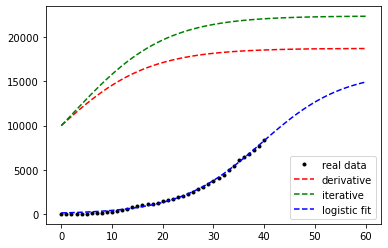

In [31]:
nb_values = len(values)
extrapolation = int(nb_values*1.5)
t = np.arange(0, extrapolation)

popt, pcov = curve_fit(logistic, t[:nb_values], values[:, 0], maxfev=10000)
initial_value = synchronize(weights, values, derivative=False)
guess = integrate(weights, [initial_value], t, derivative=False)
initial_value = synchronize(dweights, values, derivative=True)
dguess = integrate(dweights, [initial_value], t, derivative=True)
print(popt)
plt.plot(values[:, 0]*backscaling, 'k.', label='real data')
plt.plot(dguess[:, 0]*backscaling, 'r--', label='derivative')
plt.plot(guess[:, 0]*backscaling, 'g--', label='iterative')
plt.plot(t, logistic(t, *popt)*backscaling, 'b--', label='logistic fit')
plt.legend()
plt.show()

In [32]:
synchronize(weights, values)

0.9999923706054688

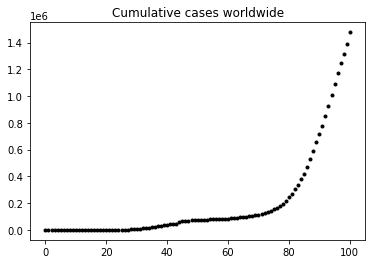

In [33]:
worldwide = data[['cases', 'day', 'month', 'year']].groupby(['year', 'month', 'day']).sum().values
worldwide = np.cumsum(worldwide)
plt.plot(worldwide, 'k.')
plt.title('Cumulative cases worldwide')
plt.show()
worldwide = worldwide.reshape(-1, 1)

In [34]:
derivatives, m = make_targets(worldwide/max(worldwide), derivative=True)
X, nb_funcs = make_polynomials(m, max_degree=3)
weights, iterations = sparse_regression(X, derivatives, cutoff=1e-2)

show_weights(weights, derivative=True)

| function   |   $\dot{x}$ |
|:-----------|------------:|
| $1$        |   0         |
| $ x$       |   0.0754754 |
| $ x^2$     |   0.10776   |
| $ x^3$     |  -0.143868  |

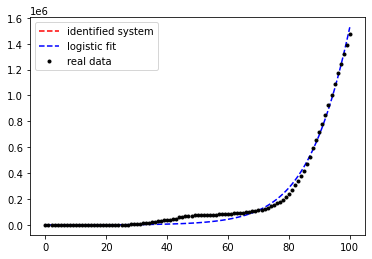

In [35]:
t = range(len(worldwide))

guess = ivp_integrate(weights, [0.0009], range(int(len(worldwide)*1)))
popt, pcov = curve_fit(logistic, t, worldwide[:, 0]/max(worldwide), maxfev=10000)

plt.plot(guess[0]*max(worldwide), 'r--', label='identified system')
plt.plot(t, logistic(t, *popt)*max(worldwide), 'b--', label='logistic fit')
plt.plot(worldwide, 'k.', label='real data')
plt.legend()
plt.show()

## Data generation

For this approach I decided to use a few indicators for each country, like total population, HDI, lattitude of the capital city.

### Countries

In [36]:
countries = ['Algeria', 'Argentina', 'Australia', 'Belgium', 'Brazil',
             'Cameroon', 'Canada', 'Chile', 'China', 'Colombia',
             'Czech_Republic', 'Dominican_Republic', 'Ecuador', 'Egypt',
             'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Iran',
             'Iraq', 'Italy', 'Kazakhstan', 'Malaysia', 'Mexico', 'Morocco',
             'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland',
             'Portugal', 'Romania', 'Russia', 'Saudi_Arabia', 'South_Africa',
             'South_Korea', 'Spain', 'Sweden', 'Thailand', 'Tunisia', 'Turkey',
             'Ukraine', 'United_Kingdom', 'United_States_of_America']

### HDIs

In [37]:
hdi = pd.read_excel('C:/Users/kipr/Downloads/Human development index and components __.xls')
hdi = hdi[['Unnamed: 1', 'Unnamed: 2']][5:197].copy()
hdi.columns = ['country', 'hdi']
hdi = hdi.set_index('country', drop=True)

hdis = {}
aliases = {'Czech_Republic': {'Czech Republic', 'Czechia'},
         'Dominican_Republic': {'Dominican Republic'},
         'Iran': {'Iran (Islamic Republic of)'},
         'Russia': {'Russian Federation'},
         'Saudi_Arabia': {'Saudi Arabia'},
         'South_Africa': {'South Africa'},
         'South_Korea': {'Korea (Republic of)', 'South Korea'},
         'United_Kingdom': {'England and United Kingdom', 'United Kingdom'},
         'United_States_of_America': {'United States'}}

for country in countries:
    try:
        hdis[country] = hdi.loc[country].values[0]
    except KeyError:
        found = False
        for alias in aliases[country]:
            try:
                hdis[country] = hdi.loc[alias].values[0]
                found = True
                break
            except KeyError:
                continue
        if not found:
            raise KeyError

### Lattitudes 

In [38]:
capitals = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_capitals_by_latitude')[1].drop_duplicates('Country')
capitals = capitals.set_index('Country', drop=True)['Latitude("−" indicates southern hemisphere)']

lattitudes = {}

for country in countries:
    try:
        lattitudes[country] = float(capitals[country].replace('−', '-'))
    except KeyError:
        found = False
        for alias in aliases[country]:
            try:
                lattitudes[country] = float(capitals[alias].replace('−', '-'))
                found = True
                break
            except KeyError:
                continue
        if not found:
            raise KeyError

### Assembling

In [39]:
rescaling = 10000
pop_rescaling = 10000000

trajectories = []
for country in countries:
    country_data = data[data['countriesAndTerritories'] == country].copy()
    country_data.loc[:, 'dateRep'] = pd.to_datetime(country_data['dateRep'], dayfirst=True)
    values = country_data.sort_values('dateRep')[['cases', 'popData2018']]
    values['cases'] = np.cumsum(values['cases'])
    # values = values.drop(columns=['popData2018'])
    values['popData2018'] = values['popData2018']/pop_rescaling
    values['hdi'] = hdis[country]*100
    values['latitude'] = lattitudes[country]
    beginning = find_beginning(values['cases'])
    values = values[beginning:]/rescaling
    trajectories.append(values.values)
    
trajectories = np.array(trajectories)

## Global model

In [40]:
dm, m = make_targets(trajectories, derivative=False, listed=True)
derivatives, m = make_targets(trajectories, derivative=True, listed=True)
X, _ = make_polynomials(m, max_degree=3)
print(X.shape, derivatives.shape, dm.shape)
dweights, _ = sparse_regression(X, derivatives, cutoff=1e-3)
weights, _ = sparse_regression(X, dm, cutoff=1e-3)

show_weights(dweights, derivative=True, variables=['1', 'x', 'p', 'i', 'l'])
show_weights(weights, derivative=False, variables=['1', 'x', 'p', 'i', 'l'])

(1659, 35) (1659, 4) (1659, 4)


| function   |   $\dot{x}$ |   $\dot{p}$ |   $\dot{i}$ |   $\dot{l}$ |
|:-----------|------------:|------------:|------------:|------------:|
| $1$        |   0.0287616 |           0 |           0 |           0 |
| $ x$       |  -0.131035  |           0 |           0 |           0 |
| $ p$       |   0.293096  |           0 |           0 |           0 |
| $ i$       |  -3.88156   |           0 |           0 |           0 |
| $ l$       |   0         |           0 |           0 |           0 |
| $ x^2$     |  -0.0919844 |           0 |           0 |           0 |
| $ x p$     |   8.017     |           0 |           0 |           0 |
| $ x i$     |  30.2451    |           0 |           0 |           0 |
| $ x l$     |   5.49091   |           0 |           0 |           0 |
| $ p^2$     |   0         |           0 |           0 |           0 |
| $ p i$     |   0         |           0 |           0 |           0 |
| $ p l$     |   0         |           0 |           0 |           0 |
| $ i^2$     |   0         |           0 |           0 |           0 |
| $ i l$     |   0         |           0 |           0 |           0 |
| $ l^2$     |   0         |           0 |           0 |           0 |
| $ x^3$     |   0         |           0 |           0 |           0 |
| $ x^2 p$   |  -0.120041  |           0 |           0 |           0 |
| $ x^2 i$   |  14.2104    |           0 |           0 |           0 |
| $ x^2 l$   | -10.6318    |           0 |           0 |           0 |
| $ x p^2$   |   0         |           0 |           0 |           0 |
| $ x p i$   |   0         |           0 |           0 |           0 |
| $ x p l$   |   0         |           0 |           0 |           0 |
| $ x i^2$   |   0         |           0 |           0 |           0 |
| $ x i l$   |   0         |           0 |           0 |           0 |
| $ x l^2$   |   0         |           0 |           0 |           0 |
| $ p^3$     |   0         |           0 |           0 |           0 |
| $ p^2 i$   |   0         |           0 |           0 |           0 |
| $ p^2 l$   |   0         |           0 |           0 |           0 |
| $ p i^2$   |   0         |           0 |           0 |           0 |
| $ p i l$   |   0         |           0 |           0 |           0 |
| $ p l^2$   |   0         |           0 |           0 |           0 |
| $ i^3$     |   0         |           0 |           0 |           0 |
| $ i^2 l$   |   0         |           0 |           0 |           0 |
| $ i l^2$   |   0         |           0 |           0 |           0 |
| $ l^3$     |   0         |           0 |           0 |           0 |

Are you sure those are not derivatives?


| function   |   $x_{k+1}$ |   $p_{k+1}$ |   $i_{k+1}$ |   $l_{k+1}$ |
|:-----------|------------:|------------:|------------:|------------:|
| $1$        |   0.0266355 |  0.00116832 |  0.00818942 |   0.0027176 |
| $ x$       |   0.845197  |  0          |  0          |   0         |
| $ p$       |   0.50114   |  0          |  0          |   0         |
| $ i$       |  -3.67323   |  0          |  0          |   0         |
| $ l$       |   0.39263   |  0          |  0          |   0         |
| $ x^2$     |  -0.0956063 |  0          |  0          |   0         |
| $ x p$     |   8.48853   |  0.1568     |  0          |   0         |
| $ x i$     |  34.1632    |  0          |  0          |   0         |
| $ x l$     |   4.02791   |  0          |  0          |   0         |
| $ p^2$     |   0         |  0          |  0          |   0         |
| $ p i$     |   0         |  0          |  0          |   0         |
| $ p l$     |   0         |  0          |  0          |   0         |
| $ i^2$     |   0         |  0          |  0          |   0         |
| $ i l$     |   0         |  0          |  0          |   0         |
| $ l^2$     |   0         |  0          |  0          |   0         |
| $ x^3$     |   0         |  0          |  0          |   0         |
| $ x^2 p$   |  -0.107306  | -0.00445559 |  0          |   0         |
| $ x^2 i$   |  14.7486    |  0          |  0          |   0         |
| $ x^2 l$   | -11.0348    |  0          |  0          |   0         |
| $ x p^2$   |   0         |  0          |  0          |   0         |
| $ x p i$   |   0         |  0          |  0          |   0         |
| $ x p l$   |   0         |  0          |  0          |   0         |
| $ x i^2$   |   0         |  0          |  0          |   0         |
| $ x i l$   |   0         |  0          |  0          |   0         |
| $ x l^2$   |   0         |  0          |  0          |   0         |
| $ p^3$     |   0         |  0          |  0          |   0         |
| $ p^2 i$   |   0         |  0          |  0          |   0         |
| $ p^2 l$   |   0         |  0          |  0          |   0         |
| $ p i^2$   |   0         |  0          |  0          |   0         |
| $ p i l$   |   0         |  0          |  0          |   0         |
| $ p l^2$   |   0         |  0          |  0          |   0         |
| $ i^3$     |   0         |  0          |  0          |   0         |
| $ i^2 l$   |   0         |  0          |  0          |   0         |
| $ i l^2$   |   0         |  0          |  0          |   0         |
| $ l^3$     |   0         |  0          |  0          |   0         |

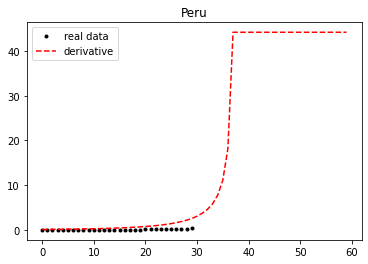

In [41]:
i = 28
values = trajectories[i]
extrapolation = int(len(values)*2)
t = np.arange(0, extrapolation)

initial_value = values[0] + [0.1, 0, 0, 0]
# initial_value = synchronize(weights, values, derivative=False)
guess = integrate(weights, initial_value, t, derivative=False)
# initial_value = synchronize(dweights, values, derivative=True)
dguess = integrate(dweights, initial_value, t, derivative=True)

plt.plot(values[:, 0], 'k.', label='real data')
plt.plot(t, dguess[:extrapolation, 0], 'r--', label='derivative')
# plt.plot(t, guess[:, 0], 'g--', label='iterative')
plt.legend()
plt.title(countries[i])
plt.show()

## Logistic predictions

In [17]:
# data = pd.read_csv('C:/Users/kipr/Downloads/téléchargement.csv')
tmp = data[data['popData2018'] > 1e7]
countries = tmp['countriesAndTerritories'].unique()
countries

array(['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Australia',
       'Bangladesh', 'Belgium', 'Benin', 'Bolivia', 'Brazil',
       'Burkina_Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Chad', 'Chile', 'China', 'Colombia', 'Cote_dIvoire', 'Cuba',
       'Czech_Republic', 'Democratic_Republic_of_the_Congo',
       'Dominican_Republic', 'Ecuador', 'Egypt', 'Ethiopia', 'France',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Haiti',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Japan',
       'Kazakhstan', 'Kenya', 'Madagascar', 'Malawi', 'Malaysia', 'Mali',
       'Mexico', 'Morocco', 'Mozambique', 'Myanmar', 'Nepal',
       'Netherlands', 'Niger', 'Nigeria', 'Pakistan', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Rwanda',
       'Saudi_Arabia', 'Senegal', 'Somalia', 'South_Africa',
       'South_Korea', 'South_Sudan', 'Spain', 'Sri_Lanka', 'Sudan',
       'Sweden', 'Syria', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey

1845.794995154617


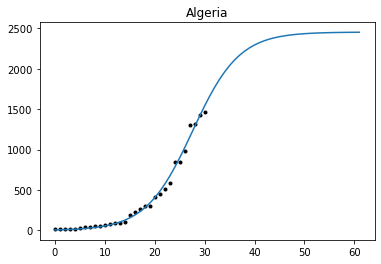

1453.5886029674946


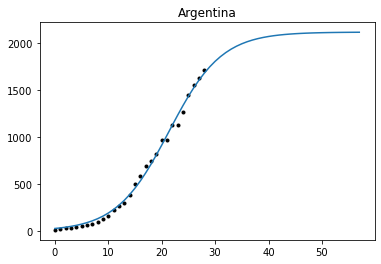

3834.723065255454


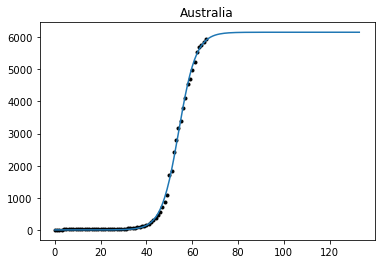

58814.13244177568


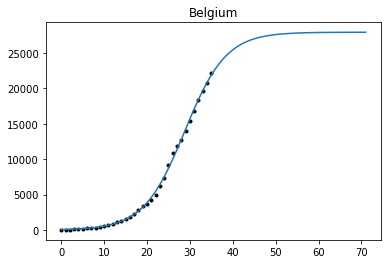

40483.700926623475


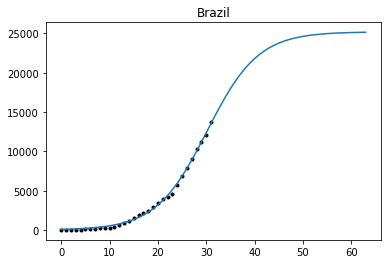

1588.5087829488743


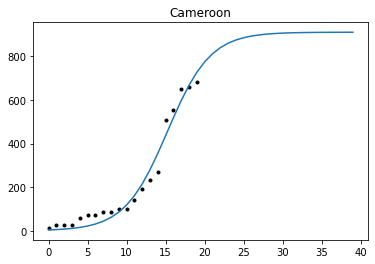

22021.15292748233


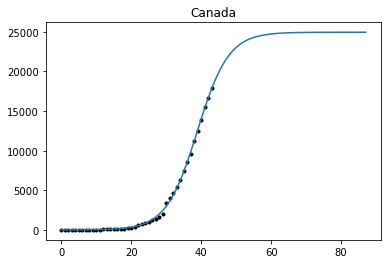

2086.256192842471


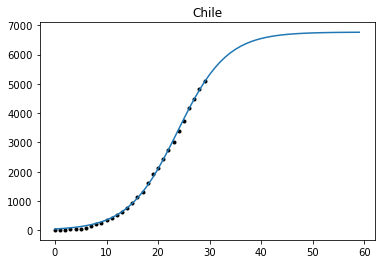

2030551.4820508482


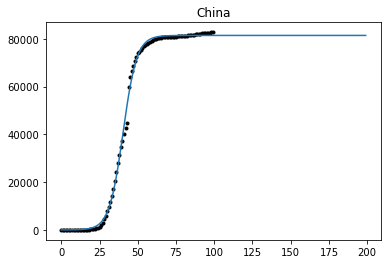

780.2460503974957


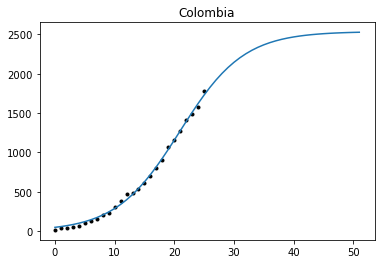

1280.6670550329688


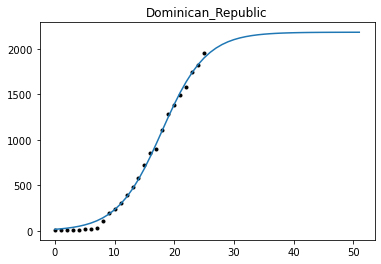

14088.529516906548


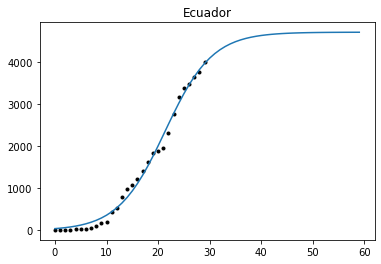

1338.9683415797008


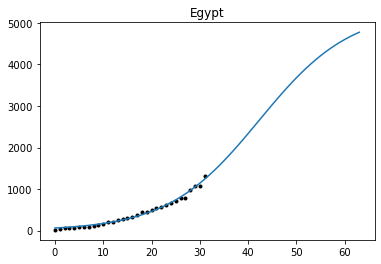

281052.4151694486


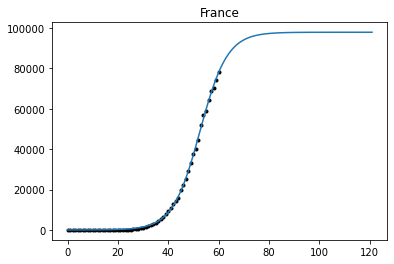

1318673.9755197435


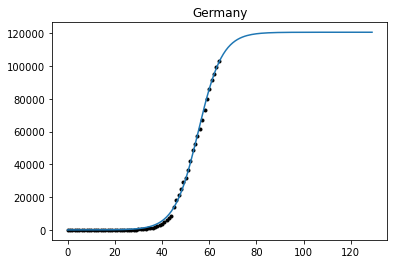

945.7182336683426


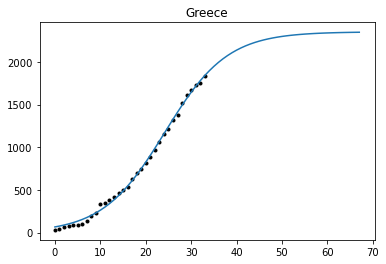

6810.866224319987


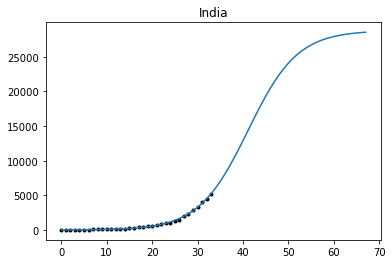

2974.8801867336538


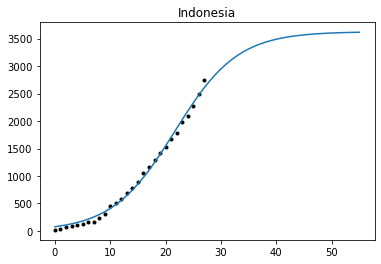

1645370.5382444756


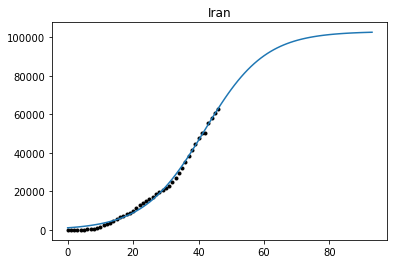

305.7026560187454


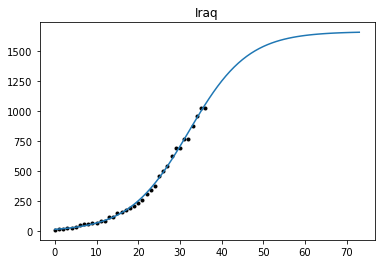

1748891.093917451


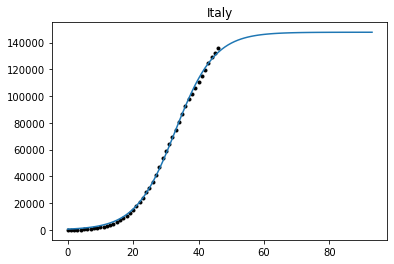

793.5707492868048


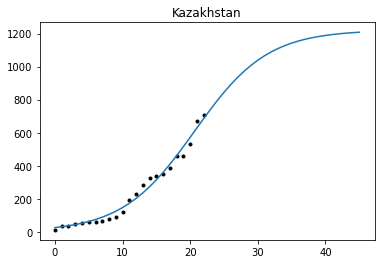

4376.061158221537


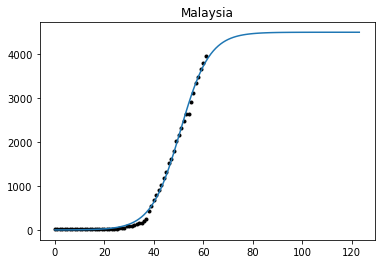

2101.789764597423


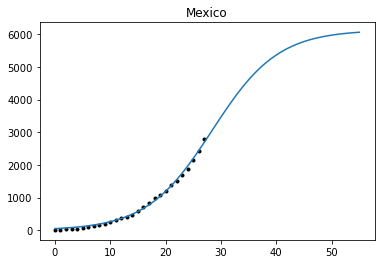

1055.6916618412436


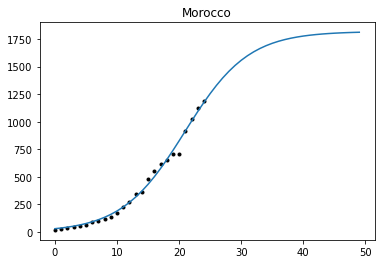

24054.29381473625


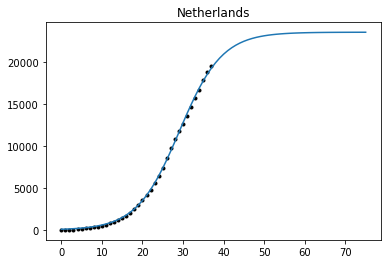

28922.901772448015


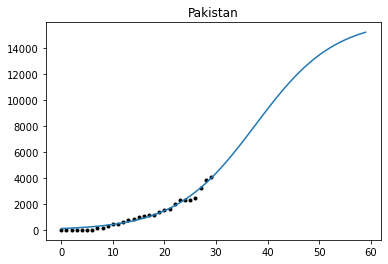

3035.8485563575578
10188.024719191688


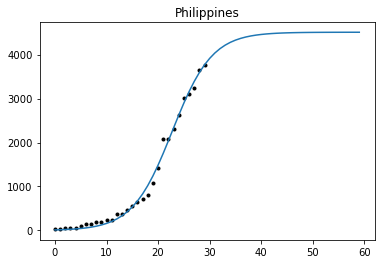

2516.1704365648725


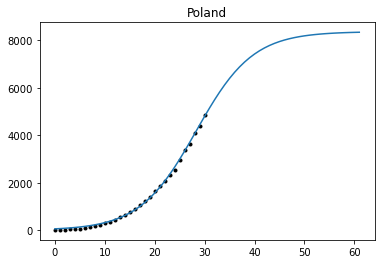

7883.047576449102


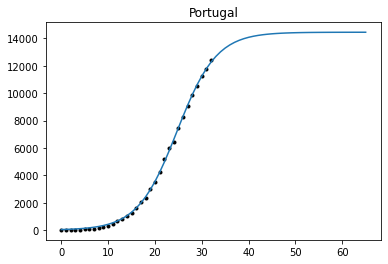

2028.8304690810262


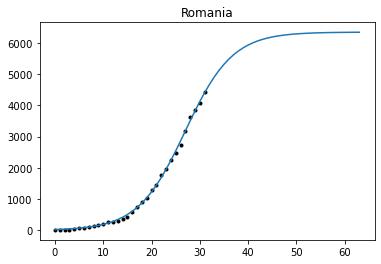

4311.241446864535


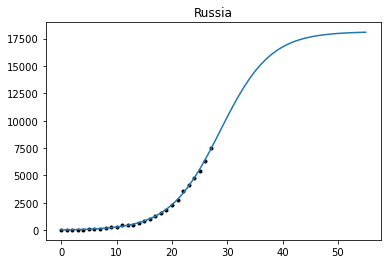

5355.32779661985


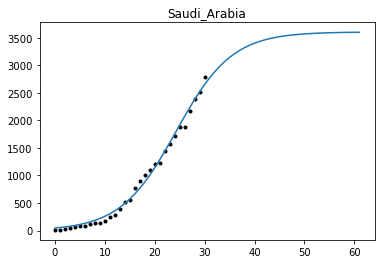

3253.0898610953823


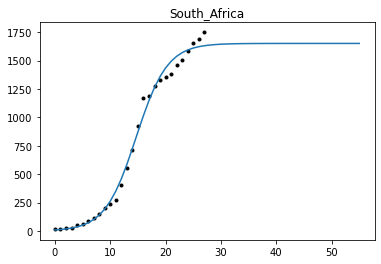

167870.40859962025


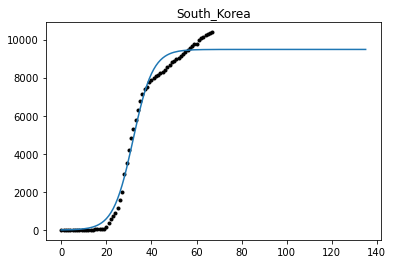

854169.1618823856


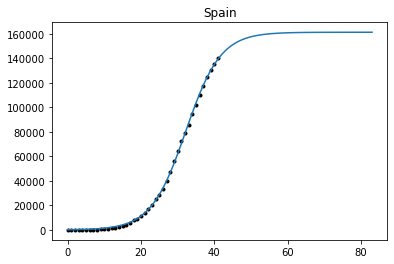

15378.55391656865


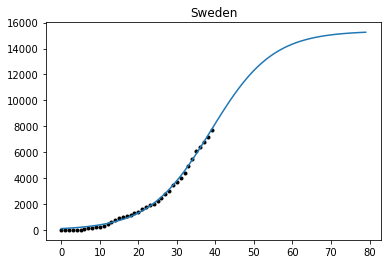

2914.536569004725


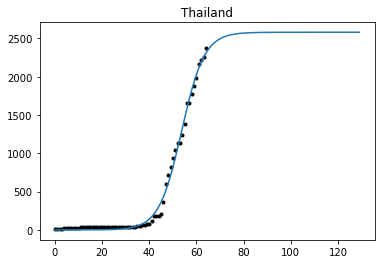

108.21635112297714


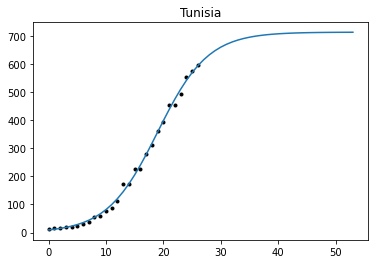

246222.46318436787


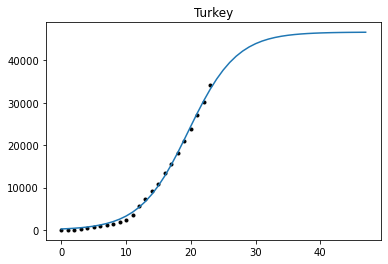

665.1491465622324


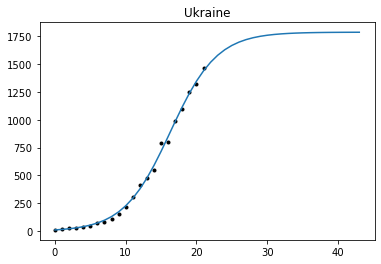

82728.03884160439


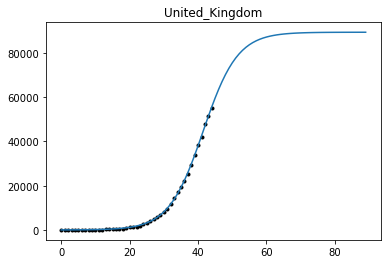

6147681.083814773


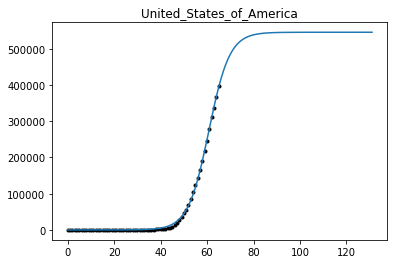

,country,start_date,final_number,a,b,c
0,Algeria,2020-03-04,2454.015158,1.671672,-0.214384,27.565176
1,Argentina,2020-03-08,2119.416263,1.235811,-0.203324,21.350462
2,Australia,2020-02-02,6152.639766,1.033015,-0.264789,54.108924
3,Belgium,2020-03-04,27948.373496,1.259276,-0.207797,28.806808
4,Brazil,2020-03-05,25199.322961,1.837087,-0.189429,30.195078
5,Cameroon,2020-03-14,911.454668,1.330591,-0.364381,15.233462
6,Canada,2020-02-25,24940.229963,1.394633,-0.224031,38.891311
7,Chile,2020-03-09,6768.946070,1.323093,-0.210153,23.796253
8,China,2019-12-31,81450.165761,0.983888,-0.222150,40.368997
9,Colombia,2020-03-10,2535.476381,1.424425,-0.187903,20.940173


In [64]:
results = []
for country in countries:
    country_data = data[data['countriesAndTerritories'] == country].copy()
    country_data.loc[:, 'dateRep'] = pd.to_datetime(country_data['dateRep'], dayfirst=True)
    values = country_data.sort_values('dateRep')[['cases', 'deaths', 'popData2018', 'dateRep']]
    # print(values)
    if len(values.index) > 1:
        date = values['dateRep'].values[0]
        values = np.cumsum(values['cases'])
        beginning = find_beginning(values)
        date = date + pd.to_timedelta(beginning, unit='D')
        values = values[beginning:]
        if len(values) < 10 or max(values) < 500:
            continue
        popt, pcov = curve_fit(logistic, (t:=range(len(values))), values/max(values), 
                               maxfev=10000)
        sol = logistic(t, *popt)*max(values)
        print(((values-sol)**2).mean())
        final_value = logistic(400, *popt)*max(values)
        if final_value < country_data['popData2018'].values[0]:# and popt[0] < 10000:
            plt.plot(t, values, 'k.')
            plt.plot(range(len(t)*2), logistic(range(len(t)*2), *popt)*max(values))
            plt.title(country)
            plt.show()
            results.append([country, date, final_value] + list(popt))
results = pd.DataFrame(results, columns=['country', 'start_date', 'final_number', 'a', 'b', 'c'])
results

In [65]:
results['final_number'].sum()

1682025.490124778

In [28]:
results['country'].values

array(['Algeria', 'Argentina', 'Australia', 'Belgium', 'Brazil',
       'Cameroon', 'Canada', 'Chile', 'China', 'Colombia',
       'Dominican_Republic', 'Ecuador', 'Egypt', 'France', 'Germany',
       'Greece', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy',
       'Kazakhstan', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands',
       'Pakistan', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Saudi_Arabia', 'South_Africa', 'South_Korea', 'Spain',
       'Sweden', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine',
       'United_Kingdom', 'United_States_of_America'], dtype=object)

In [29]:
results.to_csv('predictions_08-04-2020.csv', index=False)